In [1]:
from protein_ligand import PDBProtein, parse_sdf_file
# from reconstruct import reconstruct_from_generated
import numpy as np
import scipy.linalg
from PIL import Image, ImageDraw, ImageFont
import rdkit
from pymol import cmd
import sascorer

from rdkit import Chem, DataStructs
from rdkit.Chem import SDWriter, Descriptors, Draw, QED, rdFingerprintGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import shutil
from tqdm import tqdm
import os

In [2]:
data_path = '../../../../data/processed_2/'
crossdocked_path = '../../../../data/crossdocked/crossdocked_pocket10/crossdocked_pocket10/'

vina_dock = 'vina --receptor protein.pdbqt --ligand %s --center_x %.4f --center_y %.4f --center_z %.4f --size_x 40 --size_y 40 --size_z 40 --out %s'
vina_score = 'vina --receptor %s --ligand %s --score_only --log %s'

prepare_ligand = "C:\Python27\python.exe \"C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\\Utilities24\prepare_ligand4.py\" -l %s -v -o %s"# -A bonds_hydrogens"
prepare_protein = "C:\Python27\python.exe \"C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\\Utilities24\prepare_receptor4.py\" -r %s -o %s"# -A bonds_hydrogens"
pdbqt_to_pdb = "C:\Python27\python.exe \"C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\\Utilities24\pdbqt_to_pdb.py\" -f %s -o %s"


def load_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
print(prepare_ligand % ("ligand"+str(1)+".pdb", "ligand"+str(1)+".pdbqt"))
print(prepare_protein % ("protein"+str(1)+".pdb", "protein"+str(1)+".pdbqt"))
print(vina_score % ("protein.pdbqt","ligand.pdbqt", "log.txt"))
print(vina_dock % ("2.pdbqt", 1.3, 1.4, 1.5,"1.pdbqt"))
print(pdbqt_to_pdb % ("in.pdbqt", "out.pdb"))

C:\Python27\python.exe "C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\Utilities24\prepare_ligand4.py" -l ligand1.pdb -v -o ligand1.pdbqt
C:\Python27\python.exe "C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\Utilities24\prepare_receptor4.py" -r protein1.pdb -o protein1.pdbqt
vina --receptor protein.pdbqt --ligand ligand.pdbqt --score_only --log log.txt
vina --receptor protein.pdbqt --ligand 2.pdbqt --center_x 1.3000 --center_y 1.4000 --center_z 1.5000 --size_x 40 --size_y 40 --size_z 40 --out 1.pdbqt
C:\Python27\python.exe "C:\Program Files (x86)\MGLTools-1.5.7\Lib\site-packages\AutoDockTools\Utilities24\pdbqt_to_pdb.py" -f in.pdbqt -o out.pdb


In [4]:
index = load_file(data_path+'index.pickle')
sample_protein_ligand = load_file(data_path+index[0])

pfdim = len(sample_protein_ligand['pf'][0])
lfdim = len(sample_protein_ligand['lf'][0])

In [6]:
res = {}
affinities = []
failed = 0

for i in tqdm(range(len(index))):
    
    pl = load_file(data_path+index[i])
    p_path = pl['p']
    l_path = pl['l']
    
    os.system("obabel %s -O %s" % (crossdocked_path+l_path, "data_ligand.pdb"))
    
    ligand_prep = prepare_ligand % ("data_ligand.pdb", "data_ligand.pdbqt")
    os.system(ligand_prep)
    
    protein_prep = prepare_protein % (crossdocked_path+p_path, "data_protein.pdbqt")
    os.system(protein_prep)
    
    score_cmd = vina_score % ("data_protein.pdbqt","data_ligand.pdbqt", "data_log.txt")
    os.system(score_cmd)
    
    try:
        with open('data_log.txt', 'r') as f: log = f.readlines()
        affinity = float(log[18].split(' ')[1])
        # print(affinity)
        affinities.append(affinity)
    except:
        failed += 1
        pass
    
res['data'] = affinities
res['failed'] = failed
with open('data_affinities.obj', 'wb') as f: pickle.dump(res,f)

100%|██████████████████████████████████████████████████████████████████████████| 17953/17953 [4:19:24<00:00,  1.15it/s]


In [7]:
with open('data_affinities.obj', 'rb') as f: dat = pickle.load(f)
dat['data'][:10], dat['failed']

([-4.21087,
  -6.82166,
  -3.94583,
  -3.46705,
  -2.71776,
  -3.03533,
  -6.85848,
  -3.72341,
  -6.81347,
  -6.45894],
 0)

In [8]:
affs = np.array(dat['data'])

-6.132064099274958


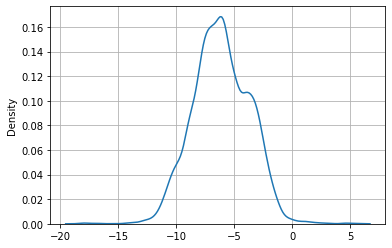

In [12]:
sns.kdeplot(data=affs[affs<6])
plt.grid()
print(np.mean(affs[affs<5]))

In [21]:
def generate_image(rdmol, filname):
    
    rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(rdmol, rdmol)
    pilimage = Draw.MolToImage(rdmol)

    # print(MolToSmiles(rdmol))

    # rdmol = AddHs(rdmol)
    # logp and qed are the same irrespective of hydrogen addition

    logp = (Descriptors.MolLogP(rdmol))
    qed = QED.qed(rdmol)
    # props = QED.properties(rdmol)
    sascore = sascorer.calculateScore(rdmol)

    res = Image.new(pilimage.mode, (300, 350), (255,255,255))
    res.paste(pilimage, (0, 50))

    I1 = ImageDraw.Draw(res)

    params = ("logp = %.2f QED = %.2f SA = %.2f" % (logp, qed, sascore))
    font = ImageFont.truetype("myfont.ttf", 15)
    # print(params)
    # Add Text to an image
    I1.text((40, 25), params, fill=(0, 0, 0), font=font)

    # Display edited image
    # res.save('./outputs/'+filname+'.png')
    return res, qed, sascore, logp

In [23]:
qeds = []
ns = []
failed = 0

for i in tqdm(range(1000)):
    try:
        mol = next(iter(Chem.SDMolSupplier('./out/'+str(i)+'.sdf')))
        rdkit.Chem.rdDepictor.GenerateDepictionMatching3DStructure(mol, mol)
        img, qed, sascore, logp = generate_image(mol, 'tmp')
        # img.save("./out/"+str(i)+".png")
        qeds.append(qed)
        ns.append(mol.GetNumAtoms())
    except:
        failed += 1
        qeds.append(-1)
        ns.append(0)

print(failed)
qeds = np.array(qeds)
ns = np.array(ns)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s][18:32:04] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:32:04] ERROR: Could not sanitize molecule ending on line 25
[18:32:04] ERROR: Explicit valence for atom # 0 N, 4, is greater than permitted
  1%|▊                                                                              | 11/1000 [00:00<00:09, 105.45it/s][18:32:04] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:04] ERROR: Could not sanitize molecule ending on line 29
[18:32:04] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:04] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:04] ERROR: Could not sanitize molecule ending on line 45
[18:32:04] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:04] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:04] ERROR: Could not sanitize m

 44%|██████████████████████████████████▍                                           | 442/1000 [00:03<00:05, 108.15it/s][18:32:08] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:32:08] ERROR: Could not sanitize molecule ending on line 25
[18:32:08] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[18:32:08] Explicit valence for atom # 6 N, 4, is greater than permitted
[18:32:08] ERROR: Could not sanitize molecule ending on line 27
[18:32:08] ERROR: Explicit valence for atom # 6 N, 4, is greater than permitted
 46%|███████████████████████████████████▌                                          | 456/1000 [00:04<00:04, 114.37it/s][18:32:08] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:08] ERROR: Could not sanitize molecule ending on line 17
[18:32:08] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
 48%|█████████████████████████████████████▍                                        | 480/1000 [00:04<00:04, 108

[18:32:12] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:12] ERROR: Could not sanitize molecule ending on line 27
[18:32:12] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
 96%|██████████████████████████████████████████████████████████████████████████▋   | 957/1000 [00:08<00:00, 112.95it/s][18:32:13] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:32:13] ERROR: Could not sanitize molecule ending on line 19
[18:32:13] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
 97%|███████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:08<00:00, 114.53it/s][18:32:13] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:32:13] ERROR: Could not sanitize molecule ending on line 34
[18:32:13] ERROR: Explicit valence for atom # 5 N, 4, is greater than permitted
 99%|█████████████████████████████████████████████████████████████████████████████▌| 994/1000 [00:08<00:00, 110

121


In [16]:
with open('model_affinities.obj', 'rb') as f: dat = pickle.load(f)
model_max_affinities = np.array(dat['model_max_affinities'])

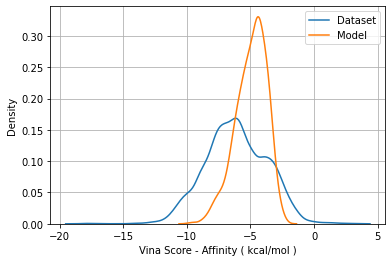

In [26]:
sns.kdeplot(data=affs[affs<4], label="Dataset")
sns.kdeplot(data = model_max_affinities[(ns>=7)*(qeds!=-1)], label = "Model")
plt.xlabel("Vina Score - Affinity ( kcal/mol )")
plt.grid()
plt.legend()
plt.show()